# 1 - NBoW

In this series we'll be building a machine learning model to perform sentiment analysis -- a subset of text classification where the task is to detect if a given sentence is positive or negative -- using [PyTorch](https://github.com/pytorch/pytorch) and [torchtext](https://github.com/pytorch/text). The dataset used will be movie reviews from the [IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/), which we'll obtain using the [datasets](https://github.com/huggingface/datasets) library.


## Introduction

In this first notebook, we'll start very simple with one of the most basic models for _NLP_ (natural language processing): a _NBoW_ (_neural bag-of-words_) model (also known as _continuous bag-of-words_, _CBoW_). The NBoW model are a strong, commonly used, baseline model for NLP tasks. They should be one of the first models you implement when performing sentiment analysis/text classification.

![](assets/nbow_model.png)

An NBoW model takes in a sequence of $T$ _tokens_, $X=\{x_1,...,x_T\} \in \mathbb{Z}^T$ and passes each token through an _embedding layer_ to obtain a sequence of _embedding vectors_. The sequence of embedding vectors is just known as an _embedding_, $E=\{e_1,...,e_T\} \in \mathbb{R}^{T \times D}$, where $D$ is known as the _embedding dimension_. It then _pools_ the embeddings across the sequence dimension to get $P \in \mathbb{R}^D$ and then finally passes $P$ through a linear layer (also known as a fully connected layer), to get a prediction, $\hat{Y} \in \mathbb{R}^C$, where $C$ is the number of classes. We'll explain what a token is, and what each of the layers -- embedding layer, pooling, and linear layer -- do in due course.

A note on notation, what does something like $E=\{e_1,...,e_T\} \in \mathbb{R}^{T \times D}$ mean? $\mathbb{R}^{T \times D}$ means a $T \times D$ sized tensor full of real numbers, i.e. a `torch.FloatTensor`. $X=\{x_1,...,x_T\} \in \mathbb{Z}^T$ is a $T$ sized tensor full of integers, i.e. a `torch.LongTensor`.


## Preparing Data

Before we can implement our NBoW model, we first have to perform quite a few steps to get our data ready to use. NLP usually requires quite a lot of data wrangling beforehand, though libraries such as `datasets` and `torchtext` handle most of this for us.

The steps to take are:

-   importing modules
-   loading data
-   tokenizing data
-   creating data splits
-   creating a vocabulary
-   numericalizing data
-   creating the data loaders


### Importing Modules

First, we'll import the required modules.

We use the `datasets` module for handling datasets, `matplotlib` for plotting our results, `numpy` for numerical processing, `torch` for tensor computations, `torch.nn` for neural networks, `torch.optim` for neural network optimizers, `torchtext` for text processing, and `tqdm` for measuring progress.


In [1]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [1]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import pandas as pd

We'll also make sure to set the random seeds for `torch` and `numpy`. This is to ensure this notebook is reproducable, i.e. we get the same results each time we run it.

It is usually good practice to run your experiments multiple times with different random seeds -- both to measure the variance of your model and also to avoid having results only calculated with either "good" or "bad" seeds, i.e. being very lucky or unlucky with the randomness in the training process.


In [2]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

### Loading the Dataset

Next, we'll load our dataset using the `datasets` library. The first argument is the name of the dataset and the `split` argument chooses which _splits_ of the data we want.

Datasets usually come in two or more _splits_, non-overlapping examples from the data, most commonly a _train split_ -- which we train our model on -- and a _test split_ -- which we evaluate our trained model on. There's also a _validation split_, which we'll talk more about later. The train, test and validation split are also commonly called the train, test and validation sets -- we'll use split and set interchangeably
in these tutorials -- and the dataset usually refers to all three of the sets combined. The IMDb dataset actually comes with a third split, called _unsupervised_, which contains a bunch of examples without labels. We don't want these so we don't include them in our `split` argument. Note that if we didn't pass an argument to `split` then it would load all available splits of the data.

How do we know that we have to use "imdb" for the IMDb dataset and that there's an "unsupervised" split? The `datasets` library has a great website used to browse the available datasets, see: https://huggingface.co/datasets/. By navigating to the [IMDb dataset page](https://huggingface.co/datasets/imdb) we can see more information specifically about the IMDb dataset.

The output received when loading the dataset tells us that it is using a locally cached version instead of downloading the dataset from online.


In [4]:
from datasets import Dataset

# Import our csv file and create a dataset with it #
df = pd.read_csv('WELFake_Dataset.csv')
df = df.dropna() # Drop records with missing values
print(df.info())

dataset = Dataset.from_pandas(df)
split_dataset = dataset.train_test_split(test_size=0.3)
train_data = split_dataset['train']
test_data = split_dataset['test']

<class 'pandas.core.frame.DataFrame'>
Index: 71537 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  71537 non-null  int64 
 1   title       71537 non-null  object
 2   text        71537 non-null  object
 3   label       71537 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.7+ MB
None


We can print out the splits which shows us the _features_ and _num_rows_ of the dataset. num*rows are the number of examples in split, as we can see, there are 25,000 examples in each. Each example in a dataset provided by the `datasets` library is a dictionary, and the features are the keys which appear in every one of those dictionaries/examples. So, each example in the IMDb dataset has a \_text* and a _label_ key.


In [5]:
train_data, test_data

(Dataset({
     features: ['Unnamed: 0', 'title', 'text', 'label', '__index_level_0__'],
     num_rows: 50075
 }),
 Dataset({
     features: ['Unnamed: 0', 'title', 'text', 'label', '__index_level_0__'],
     num_rows: 21462
 }))

We can check the `features` attribute of a split to get more information about the features. We can see that _text_ is a `Value` of `dtype=string` -- in other words, it's a string -- and that _label_ is a `ClassLabel`. A `ClassLabel` means the feature is an integer representation of which class the example belongs to. `num_classes=2` means that our labels are one of two values, 0 or 1, and `names=['neg', 'pos']` gives us the human-readable versions of those values. Thus, a label of 0 means the example is a negative review and a label of 1 means the example is a positive review.


In [6]:
train_data.features

{'Unnamed: 0': Value(dtype='int64', id=None),
 'title': Value(dtype='string', id=None),
 'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

We can look at an example by indexing into the train set. As we can see, the text is quite noisy and also rambles on quite a bit.


In [7]:
train_data[0]

{'Unnamed: 0': 61361,
 'title': "Millions of ordinary Americans support Donald Trump. Here's why\r\n",
 'text': 'Let us now address the greatest American mystery at the moment: what motivates the supporters of Republican presidential candidate Donald Trump?\r\n\r\nI call it a mystery because the working-class white people who make up the bulk of Trumps fan base show up in amazing numbers for the candidate, filling stadiums and airport hangars, but their views, by and large, do not appear in our prestige newspapers. On their opinion pages, these publications take care to represent demographic categories of nearly every kind, but blue-collar is one they persistently overlook. The views of working-class people are so foreign to that universe that when New York Times columnist Nick Kristof wanted to engage a Trump supporter last week, he made one up, along with this imaginary persons responses to his questions.\r\n\r\nWhen members of the professional class wish to understand the working-cl

### Tokenization

One of the first things we need to do to our data is _tokenize_ it. Machine learning models aren't designed to handle strings, they're design to handle numbers. So what we need to do is break down our string into individual _tokens_, and then convert these tokens to numbers. We'll get to the conversion later, but first we'll look at _tokenization_.

Tokenization involves using a _tokenizer_ to process the strings in our dataset. A tokenizer is a function that goes from a string to a list of strings. There are many types of tokenizers available, but we're going to use a relatively simple one provided by `torchtext` called the `basic_english` tokenizer. We load our tokenizer as such:


In [8]:
from torchtext import data
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


We can use the tokenizer by calling it on a string.

Notice it creates a token by splitting the word on spaces, separating punctuation into its own token, and also lowercasing every word.

The `get_tokenizer` function also supports other tokenizers, such as ones provided by [spaCy](https://spacy.io/) and [nltk](https://www.nltk.org/).


In [9]:
tokenizer("Hello world! How are you doing today? I'm doing fantastic!")

['hello',
 'world',
 '!',
 'how',
 'are',
 'you',
 'doing',
 'today',
 '?',
 'i',
 "'",
 'm',
 'doing',
 'fantastic',
 '!']

Now we have our tokenizer defined, we want to actually tokenize our data.

Each dataset provided by the `datasets` library is an instance of a `Dataset` class. We can see all the methods in a `Dataset` [here](https://huggingface.co/docs/datasets/package_reference/main_classes.html#dataset), but the main one we are interested in is [`map`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.map). By using `map` we can apply a function to every example in the dataset and either update the example or create a new feature.

We define the `tokenize_example` function below which takes in an `example`, a `tokenizer` and a `max_length` argument, tokenizes the text in the example, given by `example['text']`, trims the tokens to a maximum length and then returns a dictionary with the new feature name and feature value for that example. Note that the first argument to a function which we are going to `map` must always be the example dictionary, and it must always return a dictionary where the keys are the feature names and the values are the feature values to be added to this example.

We're trimming the tokens to a maximum length here as some examples are unnecessarily long and we can predict sentiment pretty well just using the first couple of hundred tokens -- though this might not be true for you if you're using a different dataset!


In [10]:
def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    return {"tokens": tokens}

We apply the `tokenize_example` function below, on both the train and test sets. Any arguments to the function -- that aren't the example -- need to be passed as the `fn_kwargs` dictionary, with the keys being the argument names and the values the value passed to that argument.

Operations on a `Dataset` are **not** performed in-place. You should always return the result into a new variable.

Note the warnings showing that as I have performed this `map` before, the results are cached and are thus loaded from the cache instead of being calculated again.


In [11]:
max_length = 512

train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_data = test_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

Map:   0%|          | 0/50075 [00:00<?, ? examples/s]

Map:   0%|          | 0/21462 [00:00<?, ? examples/s]

We can now see that our `train_data` has a _tokens_ feature -- as "tokens" was a key in the dictionary returned by the function we used for the `map`.


In [12]:
train_data

Dataset({
    features: ['Unnamed: 0', 'title', 'text', 'label', '__index_level_0__', 'tokens'],
    num_rows: 50075
})

By looking at the `features` attribute we can see it has automatically added the information about the tokens feature -- each is a sequence (a list) of strings. A `length=-1` means that all of our token sequences are not the same length.


In [13]:
train_data.features

{'Unnamed: 0': Value(dtype='int64', id=None),
 'title': Value(dtype='string', id=None),
 'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 '__index_level_0__': Value(dtype='int64', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

We can check the first example in our train set to see the result of the tokenization:


In [14]:
train_data[0]["tokens"][:25]

['let',
 'us',
 'now',
 'address',
 'the',
 'greatest',
 'american',
 'mystery',
 'at',
 'the',
 'moment',
 'what',
 'motivates',
 'the',
 'supporters',
 'of',
 'republican',
 'presidential',
 'candidate',
 'donald',
 'trump',
 '?',
 'i',
 'call',
 'it']

### Creating Validation Data

Next up, we'll create a _validation set_ from our data. This is similar to our test set in that we do not train our model on it, we only evaluate our model on it.

Why have both a validation set and a test set? Your test set respresents the real world data that you'd see if you actually deployed this model. You won't be able to see what data your model will be fed once deployed, and your test set is supposed to reflect that. Every time we tune our model hyperparameters or training set-up to make it do a bit better on the test set, we are leak information from the test set into the training process. If we do this too often then we begin to overfit on the test set. Hence, we need some data which can act as a "proxy" test set which we can look at more frequently in order to evaluate how well our model actually does on unseen data -- this is the validation set.

We can split a `Dataset` using the `train_test_split` method which splits a dataset into two, creating a `DatasetDict` for each split, one called `train` and another called `test` -- a bit confusing because these are our train and validation sets, not the test. We use `test_size` to set the portion of the data used for the validation set -- 0.25 means we use 25% of the training set -- and the examples are chosen randomly.


In [15]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

By showing the lengths of each split within our dataset, we can see the 25,000 training examples have now been split into 18,750 training examples and 6,250 validation examples, with the original 25,000 test examples remaining untouched.


In [16]:
len(train_data), len(valid_data), len(test_data)

(37556, 12519, 21462)

### Creating a Vocabulary

Next, we have to build a _vocabulary_. This is look-up table where every unique token in your dataset has a corresponding _index_ (an integer).

We do this as machine learning models cannot operate on strings, only numerical vaslues. Each _index_ is used to construct a _one-hot_ vector for each token. A one-hot vector is a vector where all the elements are 0, except one, which is 1, and the dimensionality is the total number of unique tokens in your vocabulary, commonly denoted by $V$.

For example:

![](assets/vocabulary.png)

One issue with creating a vocabulary using every single word in the dataset is that there are usually a considerable amount of unique tokens. One way to combat this is to either only construct the vocabulary only using the most commonly appearing tokens, or to only use tokens which appear a minimum amount of times in the dataset. In this notebook, we do the latter, keeping on the tokens which appear 5 times.

What happens to tokens which appear less than 5 times? We replace them with a special _unknown_ token, denoted by `<unk>`. For example, if the sentence "This film is great and I love it", but the word "love" was not in the vocabulary, it would become: "This film is great and I \<unk\> it".

We use the `build_vocab_from_iterator` function from `torchtext.vocab` to create our vocabulary, specifying the `min_freq` (the minimum amount of times a token should appear to be added to the vocabulary) and `special_tokens` (tokens which should be appended to the start of the vocabulary, even if they don't appear `min_freq` times in the dataset).

The first special token is our unknown token, the other, `<pad>` is a special token we'll use for padding sentences.

When we feed sentences into our model, we pass a _batch_ of sentences, i.e. more than one, at the same time. Passing a batch of sentences is preferred to passing sentences one at a time as it allows our model to perform computation on all sentences within a batch in paralle, thus speeding up the time taken to train and evaluate our model. All sentences within a batch need to be the same length (in terms of the number of tokens). Thus, to ensure each sentence is the same length, any shorter than the longest sentence need to have padding tokens appended to the end of them.

For an example batch of two sentences of length four and three tokens:

![](assets/padding.png)

As we can see, the second sentence has been padded with a single `<pad>` token.


In [17]:
from torchtext import vocab
min_freq = 5
special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


Why is the vocabulary built from only the training data? When testing any machine learning system, we want to avoid any form of data leakage but not using any information from the test data -- this includes the frequency of tokens within the test data. As the validation set is supposed to reflect the test set as much as possible, we also do not use it to build the vocabulary. A common mistake is building the vocabulary using validation and test data -- do not do this!

Now we have our vocabulary, we can first examine it by checking its length -- the number of tokens in the vocabulary.


In [18]:
len(vocab)

50230

We can view the tokens in our vocabulary using the `get_itos` method, which returns a list of strings (tokens), and the index of each token in the list is the index of the token in our vocabulary.


In [19]:
vocab.get_itos()[:10]

['<unk>', '<pad>', 'the', ',', '.', 'to', 'of', 'a', 'and', 'in']

We can get the index of a token by accessing it like a dictionary.


In [20]:
vocab["and"]

8

We store the indices of the unknown and padding tokens (zero and one, respectively) in variables, as we'll use these further on in this notebook.


In [21]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

We can check if a token is in our vocabulary using the `in` operator.


In [22]:
"trump" in vocab

True

By default, a vocabulary created by `torchtext` will throw an error if you attempt to obtain the index of a token which is not in the vocabulary, i.e. `vocab["some_token"]` will throw an error.

We need to explicity tell the vocabulary which token to return if we pass a token not in the vocabulary. We do this using the `set_default_index` method, passing in the index we wish it to return. Here, we pass the index of the unknown token.


In [23]:
vocab.set_default_index(unk_index)

Now, when trying to get the index of a token that is not in the vocabulary, instead of throwing an error we get zero, the value of `unk_index`, our unknown token, `<unk>`.


In [24]:
vocab["some_token"]

0

To look-up a list of tokens, we can use the vocabulary's `lookup_indices` method.


In [25]:
vocab.lookup_indices(["hello", "world", "some_token", "<pad>"])

[12451, 154, 0, 1]

### Numericalizing Data

Now we have our vocabulary, we can numericalize our data. This involves converting the tokens within our dataset into indices. Similar to how we tokenized our data using the `Dataset.map` method, we'll define a function that takes an example and our vocabulary, gets the index for each token in each example and then creates an `ids` field which containes the numericalized tokens.


In [26]:
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

We then apply this function to all examples in the training, validation and testing datasets.


In [27]:
test_data_text = test_data

In [28]:
train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

Map:   0%|          | 0/37556 [00:00<?, ? examples/s]

Map:   0%|          | 0/12519 [00:00<?, ? examples/s]

Map:   0%|          | 0/21462 [00:00<?, ? examples/s]

Checking an example, we can see that the `id` field now consists of the indexes of the tokens from that example.


In [29]:
train_data[0]["tokens"][:10]

['14', 'shares', '4', '9', '0', '1', 'it', "'", 's', 'a']

In [30]:
vocab.lookup_indices(train_data[0]["tokens"][:10])

[1219, 2624, 460, 739, 1147, 247, 15, 88, 14, 7]

In [31]:
train_data[0]["ids"][:10]

[1219, 2624, 460, 739, 1147, 247, 15, 88, 14, 7]

The final step of numericalization is transforming the `ids` and `label` from integers into PyTorch tensors, which we do using the `with_format` method.

We do this because our PyTorch models work with tensors, and not integers.


In [32]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

In [33]:
train_data[0]["label"]

tensor(1)

In [34]:
train_data[0]["ids"][:10]

tensor([1219, 2624,  460,  739, 1147,  247,   15,   88,   14,    7])

One thing to note is that when using `with_format`, all the columns not specified (`"tokens"` and `"text"`) are removed from the example.


In [35]:
train_data[0].keys()

dict_keys(['label', 'ids'])

Removing the "tokens" field is fine, as if we wanted to retrieve the human-readable tokens again we can simply convert the tensor into a Python list of integers and then use the vocabulary's `lookup_tokens` method.


In [36]:
vocab.lookup_tokens(train_data[0]["ids"][:10].tolist())

['14', 'shares', '4', '9', '0', '1', 'it', "'", 's', 'a']

### Creating Data Loaders

The final step of preparing the data is creating the data loaders. We can iterate over a data loader to retrieve batches of examples. This is also where we will perform any padding that is necessary.

We first need to define a function to _collate_ a batch, consisting of a list of examples, into what we want our data loader to output.

Here, our desired output from the data loader is a dictionary with keys of `"ids"` and `"label"`.

The value of `batch["ids"]` should be a tensor of shape `[batch size, length]`, where `length` is the length of the longest sentence (in terms of tokens) within the batch, and all sentences shorter than this should be padded to that length.

The value of `batch["label"]` should be a tensor of shape `[batch size]` consisting of the label for each sentence in the batch.

We define a function, `get_collate_fn`, which is passed the pad token index and returns the actual collate function. Within the actual collate function, `collate_fn`, we get a list of `"ids"` tensors for each example in the batch, and then use the `pad_sequence` function, which converts the list of tensors into the desired `[batch size, length]` shaped tensor and performs padding using the specified `pad_index`. By default, `pad_sequence` will return a `[length, batch size]` shaped tensor, but by setting `batch_first=True`, these two dimensions are switched. We get a list of `"label"` tensors and convert the list of tensors into a single `[batch size]` shaped tensor.


In [37]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

Next, we define a function which returns our actual data loader. It takes in a dataset, desired batch size (the number of sentences we want in a batch), our padding token index, and if the dataset should be shuffled.


In [38]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

Finally, we get the data loaders for the training, validation and test data.

We set the batch size equal to 512. Our batch size should be set as high as we can, as larger batches means more parallel computation, less compute time, and thus faster training and evaluation.

Only the training data loader needs to be shuffled, as it's the only one used to actually tune the parameters within the model, and your training data should always be shuffled.


In [39]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

## Building the Model


In [40]:
class NBoW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, ids):
        # ids = [batch size, seq len]
        embedded = self.embedding(ids)
        # embedded = [batch size, seq len, embedding dim]
        pooled = embedded.mean(dim=1)
        # pooled = [batch size, embedding dim]
        prediction = self.fc(pooled)
        # prediction = [batch size, output dim]
        return prediction

In [41]:
vocab_size = len(vocab)
embedding_dim = 300
output_dim = len(train_data.unique("label"))

model = NBoW(vocab_size, embedding_dim, output_dim, pad_index)

In [42]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 15,069,602 trainable parameters


In [43]:
vectors = torchtext.vocab.GloVe()

In [44]:
hello_vector = vectors.get_vecs_by_tokens("hello")

In [45]:
hello_vector.shape

torch.Size([300])

In [46]:
hello_vector[:32]

tensor([ 0.2523,  0.1018, -0.6748,  0.2112,  0.4349,  0.1654,  0.4826, -0.8122,
         0.0413,  0.7850, -0.0779, -0.6632,  0.1464, -0.2929, -0.2549,  0.0193,
        -0.2026,  0.9823,  0.0283, -0.0813, -0.1214,  0.1313, -0.1765,  0.1356,
        -0.1636, -0.2257,  0.0550, -0.2031,  0.2072,  0.0958,  0.2248,  0.2154])

In [47]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [48]:
pretrained_embedding.shape

torch.Size([50230, 300])

In [49]:
model.embedding.weight

Parameter containing:
tensor([[-0.1117, -0.4966,  0.1631,  ..., -0.5592, -0.4480, -0.6476],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.7882, -1.6625, -0.7064,  ..., -1.5841, -0.3711, -1.2338],
        ...,
        [-0.6271,  0.3452, -1.1129,  ...,  0.3253,  0.3316,  0.3613],
        [ 2.0939, -1.4660,  0.2682,  ..., -0.5993, -1.6204,  1.9712],
        [-0.1833,  2.4976, -0.7860,  ...,  2.0465, -1.0554,  0.6749]],
       requires_grad=True)

In [50]:
pretrained_embedding

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2720, -0.0620, -0.1884,  ...,  0.1302, -0.1832,  0.1323],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [51]:
model.embedding.weight.data = pretrained_embedding

In [52]:
model.embedding.weight

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2720, -0.0620, -0.1884,  ...,  0.1302, -0.1832,  0.1323],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)

In [53]:
optimizer = optim.Adam(model.parameters())

In [54]:
criterion = nn.CrossEntropyLoss()

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [56]:
model = model.to(device)
criterion = criterion.to(device)

In [57]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [58]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [59]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [60]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "nbow.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 25/25 [00:00<00:00, 38.73it/s]


epoch: 0
train_loss: 0.626, train_acc: 0.764
valid_loss: 0.529, valid_acc: 0.848


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 39.58it/s]


epoch: 1
train_loss: 0.437, train_acc: 0.864
valid_loss: 0.360, valid_acc: 0.890


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 35.17it/s]


epoch: 2
train_loss: 0.309, train_acc: 0.906
valid_loss: 0.273, valid_acc: 0.921


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 39.83it/s]


epoch: 3
train_loss: 0.236, train_acc: 0.934
valid_loss: 0.223, valid_acc: 0.938


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 39.89it/s]


epoch: 4
train_loss: 0.190, train_acc: 0.951
valid_loss: 0.191, valid_acc: 0.948


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 35.08it/s]


epoch: 5
train_loss: 0.159, train_acc: 0.961
valid_loss: 0.170, valid_acc: 0.953


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 39.15it/s]


epoch: 6
train_loss: 0.136, train_acc: 0.967
valid_loss: 0.154, valid_acc: 0.957


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 35.64it/s]


epoch: 7
train_loss: 0.117, train_acc: 0.972
valid_loss: 0.142, valid_acc: 0.960


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 36.99it/s]


epoch: 8
train_loss: 0.103, train_acc: 0.977
valid_loss: 0.132, valid_acc: 0.963


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 35.10it/s]

epoch: 9
train_loss: 0.090, train_acc: 0.980
valid_loss: 0.125, valid_acc: 0.964


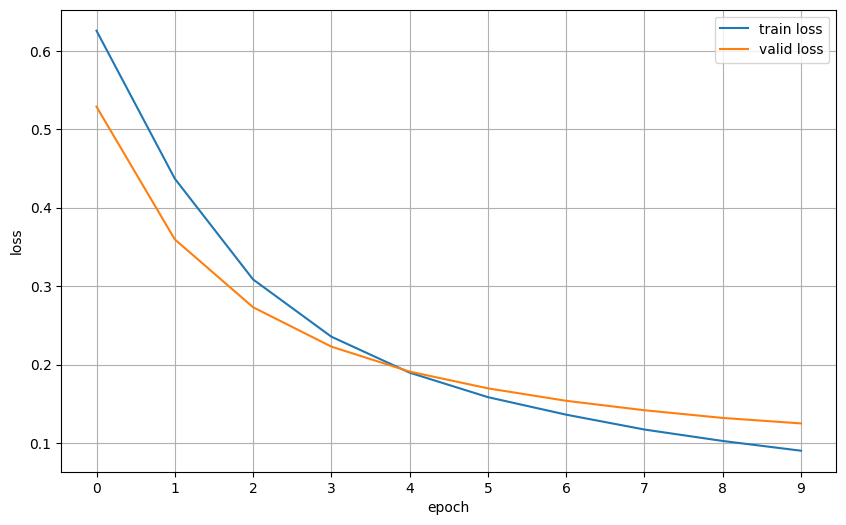

In [61]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

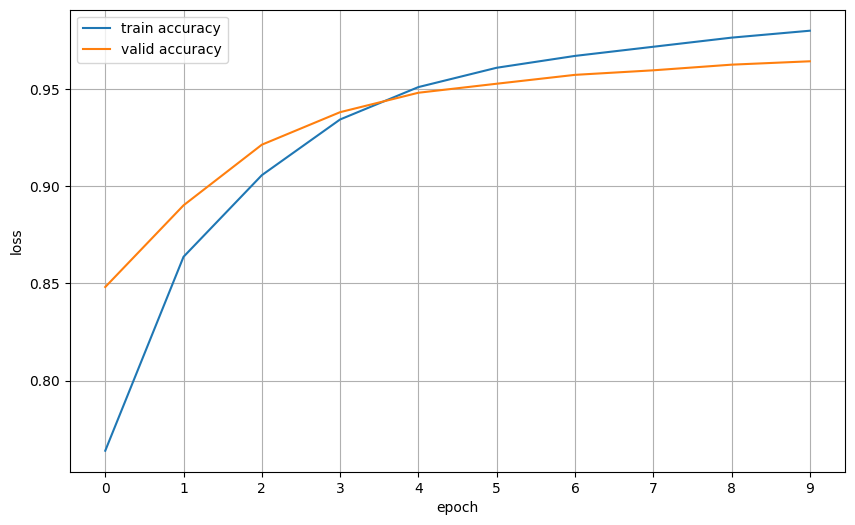

In [62]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [63]:
model.load_state_dict(torch.load("nbow.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

evaluating...: 100%|██████████| 42/42 [00:01<00:00, 35.62it/s]


In [64]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.127, test_acc: 0.961


In [65]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [68]:
true_pos = 0
true_neg = 0
false_neg = 0
false_pos = 0

i = 0
for datapoint in test_data＿text:
    if i % 100 == 0:
        print(i)
    predicted_class, predicted_probability = predict_sentiment(datapoint["text"], model, tokenizer, vocab, device)
    if predicted_class == datapoint["label"] == 1:
        true_pos += 1
    elif predicted_class == datapoint["label"] == 0:
        true_neg += 1
    elif predicted_class != datapoint["label"] and predicted_class == 0:
        false_neg += 1
    elif predicted_class != datapoint["label"] and predicted_class == 1:
        false_pos += 1
    i += 1

percision = true_pos/(true_pos + false_pos)
recall = true_pos/(true_pos + false_neg)
f1 = (2*percision*recall)/(percision+recall)

print("percision",percision)
print("recall",recall)
print("f1",f1)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

Let's feed some test cases into our model to see how well it can detect fake news that we provide. After going through our model's raw text data, it is apparent that much of the training is done using political news articles. Here we pass in three political texts to analyze the predicted label and probability.